Eсть данные АА-теста с '2022-12-25' по '2022-12-31'. 
Hужно сделать симуляцию, как будто были проведены 10000 АА-тестов. 
На каждой итерации нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. 
Провести сравнение этих подвыборок t-testом
1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p-values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает система сплитования.


In [9]:
# Запрос библиотек
import pandahouse
import pandas as pd
import seaborn as sns
import numpy as np

from scipy import stats

In [2]:
# Создание соединения

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}


In [3]:
# Запрос данных (пользователи, их просмотры и лайки из групп 2 и 3
#  во временной интервал с 25.12.22 по 31.12.22)

q = """
SELECT  
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr,
    exp_group
    
FROM simulator_20230120.feed_actions

WHERE toDate(time) >= '2022-12-25' and toDate(time) <= '2022-12-31' 
    and exp_group in (2,3)
    
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [ ]:
# Смотрим количество пользователей в группах. Нам нужно примерно одинаковое

df.groupby('exp_group').count()

Количество пользователей в группах (8480 и 8469) достаточно близко 

<AxesSubplot:xlabel='ctr', ylabel='Count'>

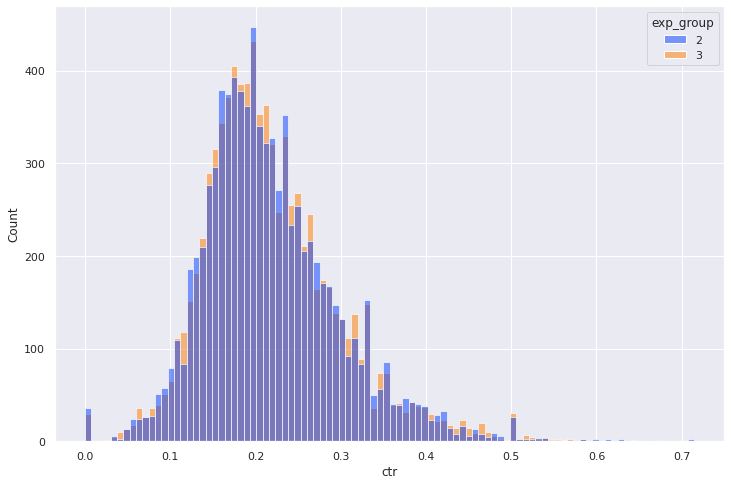

In [5]:
# Визуальный просмотр групп в Seaborn


sns.set(rc={'figure.figsize':(12,8)})

sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = 'bright',
              alpha=0.5,
              kde=False)

На вид CTR в группах распределён одинаково.

In [ ]:
# T-test для оценки различий в двух группах
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

Значение p-value много больше порога в 0,05.
Можем достаточно уверенно принять нулевую гипотезу о том, что значительного различия в двух группах по CTR нет.




In [11]:
''' Подготовка к симуляции 10000 АА-тестов. 
На каждой итерации будем формировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. 
'''

num_AA = 10000                    # Количество АА тестов
sample_number = 500               # Количество пользователей в каждой выборке
df_2 = df[df.exp_group == 2].ctr  # Колонка с CTR во всей группе 2
df_3 = df[df.exp_group == 3].ctr  # Колонка с CTR во всей группе 3
p_value_list = np.zeros(num_AA)   # Список под значения p-values, изначально заполненный нулями


In [15]:
# List Comprhention для записи всех значений p_value в 10000 экспериментах, в заранее подготовленный список

p_value_list = [stats.ttest_ind(df_2.sample(sample_number),df_3.sample(sample_number),equal_var=False).pvalue \
                for _ in range(num_AA)]


In [16]:
# Выбор значений p-value, которые меньше выбранного порога в 5% и вычисление доли этих значений к общему числу тестов.

p_value_less_005 = [x for x in p_value_list if x <= 0.05]   # Формируем список из значений меньше 0,05

ratio_p_value_less005 = len(p_value_less_005) / num_AA      # Вычисляем долю значений p-value, которые меньше 0,05

print(f' Процент p-value, меньших чем 0.05, равен {ratio_p_value_less005*100}')

 Процент p-value, меньших чем 0.05, равен 4.99


In [17]:
# Подготовка для построении гистограммы распределения значений p-value


df_p_value = pd.DataFrame(p_value_list,columns={'p_value'}) # Формируем pandas DataFrame из списка p_value_list


<AxesSubplot:xlabel='p_value', ylabel='Count'>

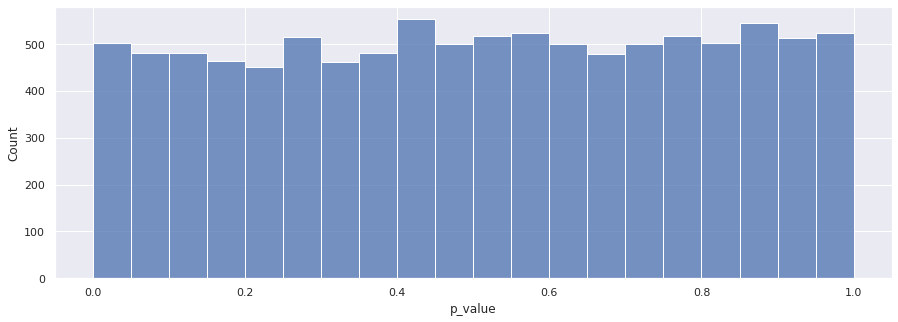

In [34]:
# Строим гистограмму в Seaborn

sns.set(rc={'figure.figsize':(15,5)})
sns.histplot(x = df_p_value.p_value, bins = 20) # Берём bins = 20, чтобы видеть количество p-value меньше 0,05

Распределение значений p-value похоже на равномерное

Количество значений p-value меньших 0.05 не превышает 5 %

Это позволяет сделать вывод - сплитование работает корректно и подходит для проведения АВ тестов  